<a href="https://colab.research.google.com/github/GeneSUN/time-series-analysis-toolkit/blob/main/Forecast_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Metric functions ----
def absolute_error(a, f):
    return np.abs(a - f)

def squared_error(a, f):
    return (a - f) ** 2

def absolute_percent_error(a, f):
    # Avoid division by zero; mark as NaN where |a| == 0
    denom = np.where(np.abs(a) > 0, np.abs(a), np.nan)
    return np.abs(a - f) / denom

def symmetric_error(a, f, eps=1e-12):
    denom = np.abs(a) + np.abs(f) + eps
    return 2.0 * np.abs(a - f) / denom

def relative_absolute_error(a, f, f_star, eps=1e-12):
    denom = np.abs(a - f_star) + eps
    return np.abs(a - f) / denom

def absolute_scaled_error(a, f, scale):
    return np.abs(a - f) / scale

intrinsic_metrics = [
    "absolute_error",
    "squared_error",
    "absolute_percent_error",
    "symmetric_error",
]


# Time Series Metrics
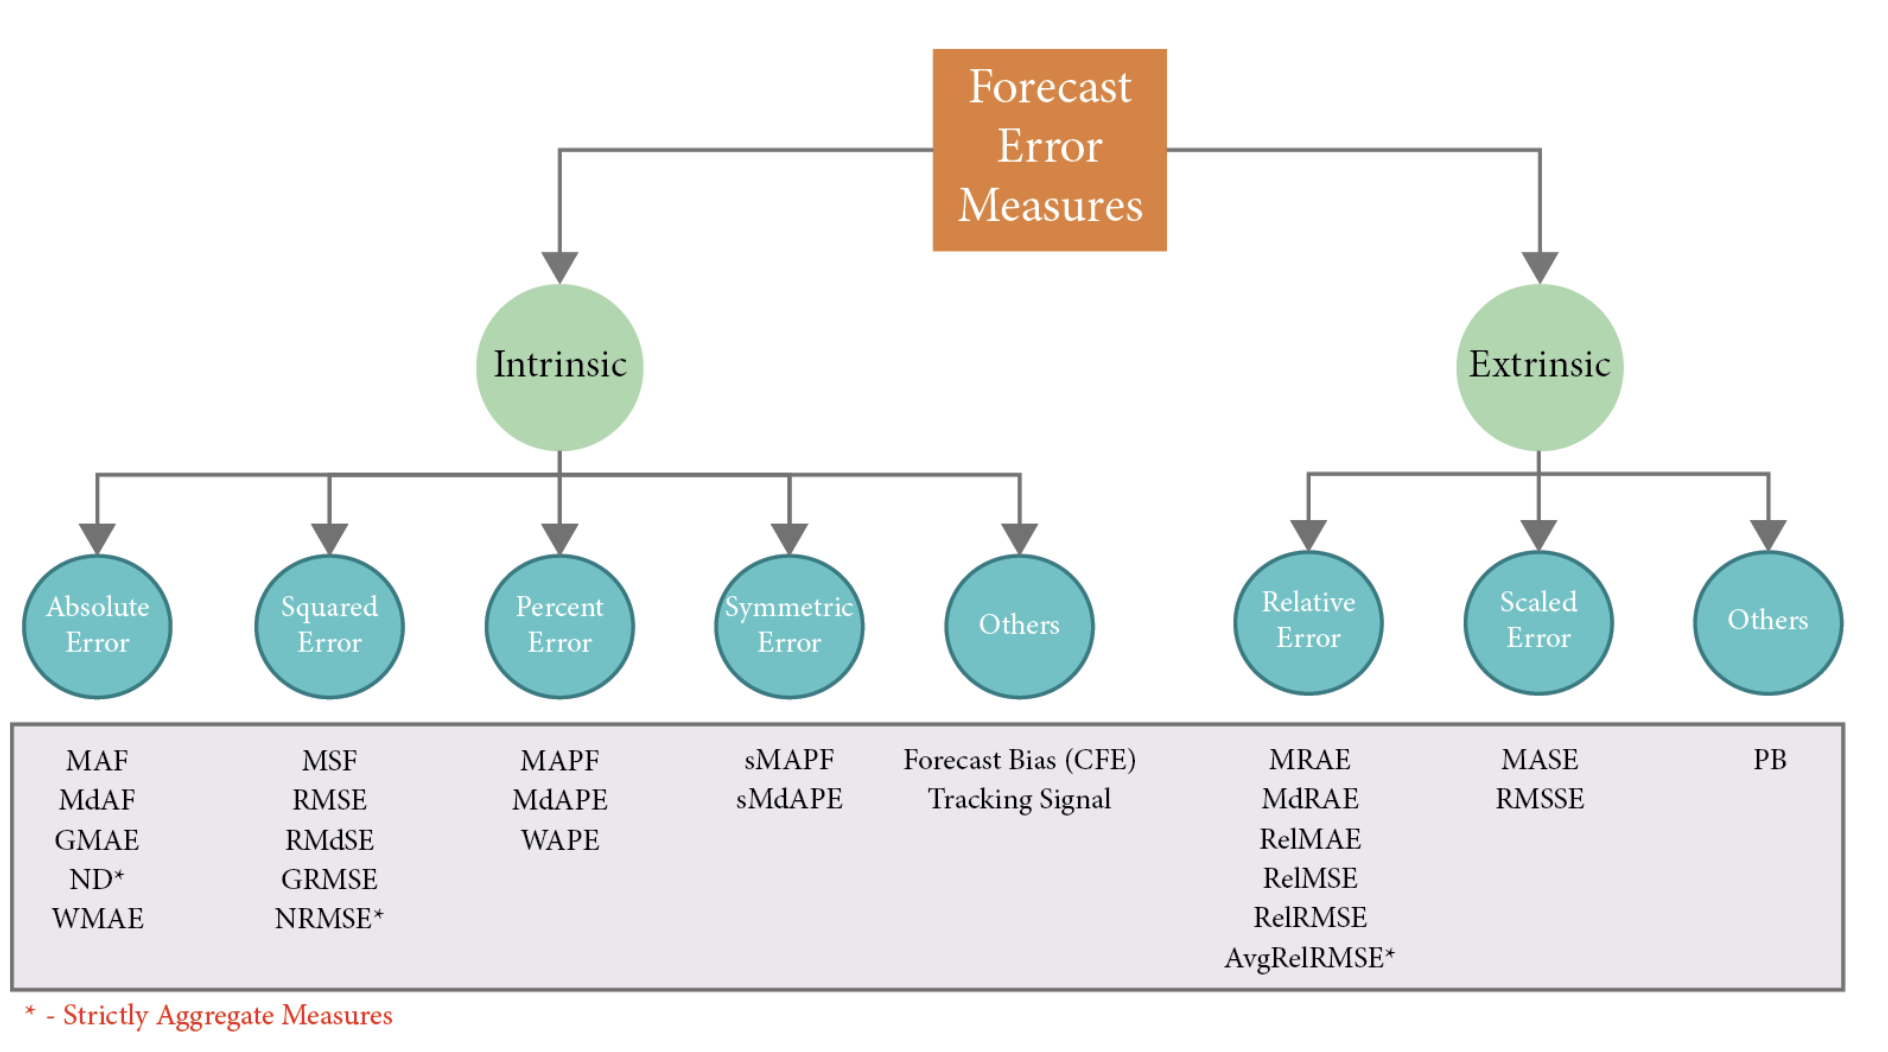

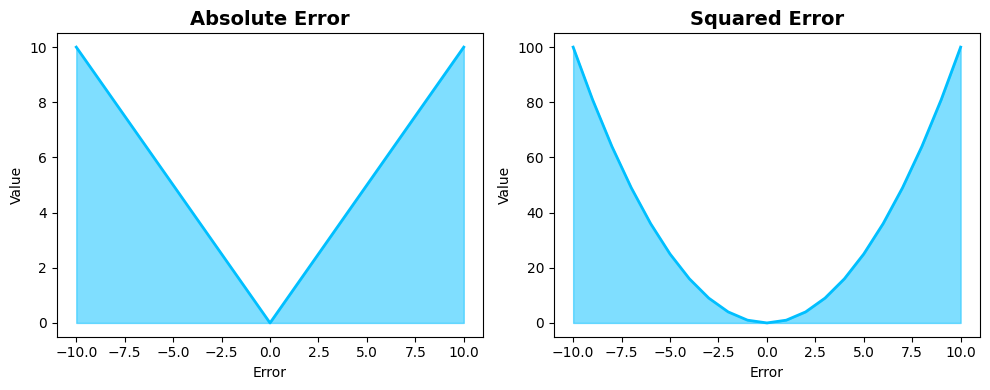

In [4]:
#@title 1). Absolute Error and Squared Error
# Fix actual so APE is well-defined


a_const = 5.0
errors = np.arange(-10, 11, 1)  # e = a - f
records = []
for e in errors:
    f = a_const - e
    records.append({
        "error": e,
        "absolute_error": absolute_error(a_const, f),
        "squared_error": squared_error(a_const, f),
        "absolute_percent_error": absolute_percent_error(a_const, f),
        "symmetric_error": symmetric_error(a_const, f),
    })
metric_df_a = pd.DataFrame(records).sort_values("error")
metric_df_a.head()


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
axes = axes.flatten()
titles = [m.replace("_", " ").title() for m in intrinsic_metrics[:2]]

for ax, metric, title in zip(axes, intrinsic_metrics, titles):
    ax.fill_between(metric_df_a["error"], metric_df_a[metric], color="deepskyblue", alpha=0.5)
    ax.plot(metric_df_a["error"], metric_df_a[metric], color="deepskyblue", lw=2)
    ax.set_title(title, fontsize=14, weight="bold")
    ax.set_xlabel("Error")
    ax.set_ylabel("Value")

plt.tight_layout()
plt.show()


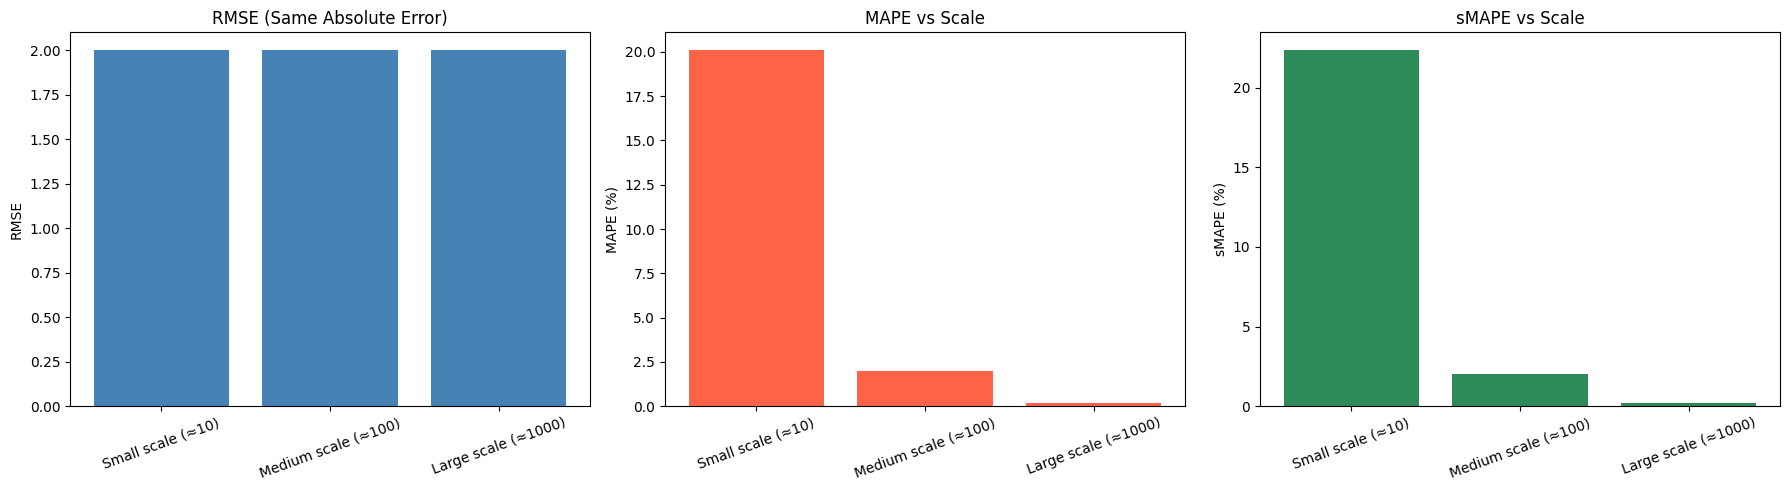

              Scenario  RMSE   MAPE (%)  sMAPE (%)
0    Small scale (≈10)   2.0  20.095718  22.353757
1  Medium scale (≈100)   2.0   2.009572   2.030068
2  Large scale (≈1000)   2.0   0.200957   0.201160


In [6]:
#@title 2). Percent Error and Symmetric Error
#@markdown Normalized by actual value or predicted value. (similar to normalization for supervised learning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

# --- Construct 3 scenarios: same absolute error, different magnitudes ---
np.random.seed(0)
n = 20

scenarios = {
    "Small scale (≈10)": 10 + np.sin(np.linspace(0, 2*np.pi, n)),
    "Medium scale (≈100)": 100 + 10*np.sin(np.linspace(0, 2*np.pi, n)),
    "Large scale (≈1000)": 1000 + 100*np.sin(np.linspace(0, 2*np.pi, n)),
}

records = []
for name, a in scenarios.items():
    f = a - 2.0   # SAME absolute error at every point
    e = f - a
    abs_e = np.abs(e)

    rmse = sqrt(np.mean(e**2))         # = 2.0
    mape = np.mean(abs_e / np.abs(a)) * 100.0
    smape = np.mean(2*abs_e / (np.abs(a) + np.abs(f))) * 100.0

    records.append({
        "Scenario": name,
        "RMSE": rmse,
        "MAPE (%)": mape,
        "sMAPE (%)": smape
    })

metrics_df = pd.DataFrame(records)

# --- Create 1x3 subplots ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: RMSE
axes[0].bar(metrics_df["Scenario"], metrics_df["RMSE"], color="steelblue")
axes[0].set_title("RMSE (Same Absolute Error)")
axes[0].set_ylabel("RMSE")
axes[0].tick_params(axis="x", rotation=20)

# Plot 2: MAPE
axes[1].bar(metrics_df["Scenario"], metrics_df["MAPE (%)"], color="tomato")
axes[1].set_title("MAPE vs Scale")
axes[1].set_ylabel("MAPE (%)")
axes[1].tick_params(axis="x", rotation=20)

# Plot 3: sMAPE
axes[2].bar(metrics_df["Scenario"], metrics_df["sMAPE (%)"], color="seagreen")
axes[2].set_title("sMAPE vs Scale")
axes[2].set_ylabel("sMAPE (%)")
axes[2].tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

# Display metrics table
print(metrics_df)


**Symmetric Mean Absolute Percent Error (sMAPE) favor over-forecasting**

  $$ sMAPE = \frac{1}{H} \sum_{t=1}^{H} \frac{200 \, |e_t|}{|y_t| + |\hat{y}_t|} $$

* if y_predicted is larger, the error become smaller


**Struggling with Zero**
- Both these two method struggle when the actual value is near 0. In fact, you can not run the script when there are so many zeros.
- In this case, WAPE is an alternative



  - **Percent error favor underforecasting**
  - **Symmetric error favor over-forecasting**

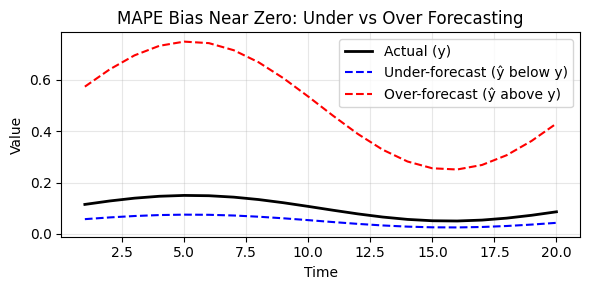

In [17]:
#@title MAPE Bias Near Zero: Under vs Over Forecasting
import numpy as np
import matplotlib.pyplot as plt

# Simulate small actual values near zero
x = np.arange(1, 21)
actual = 0.1 + 0.05*np.sin(0.3*x)   # Actual values slightly > 0
under_forecast = actual * 0.5       # Conservative forecast (below actual, above 0)
over_forecast = actual * 5          # Aggressive overestimation (beyond actual)

# Plot
plt.figure(figsize=(6,3))
plt.plot(x, actual, label="Actual (y)", color="black", linewidth=2)
plt.plot(x, under_forecast, label="Under-forecast (ŷ below y)", linestyle="--", color="blue")
plt.plot(x, over_forecast, label="Over-forecast (ŷ above y)", linestyle="--", color="red")

plt.title("MAPE Bias Near Zero: Under vs Over Forecasting")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 3). Relative measures
- **Relative Absolute Error (RAE):**

  $$ RAE = \frac{|y_t - \hat{y}_t|}{|y_t - \hat{y}^*|} $$

  where $\hat{y}^*$ is a reference forecast

  * Relative measures are a good alternative to percent-error-based metrics.
  * It compare the forecast’s errors to those of a benchmark, highlighting the forecast’s relative improvement.

---

- **Absolute Scaled Error (ASE):**

  - if  $\hat{y}^*$ in Relative Absolute Error is a naive forecast, it become **Scaled Error**.

  $$ ASE = \frac{|y_t - \hat{y}_t|}{|y_t - y_{t-1}|} $$





=== Metrics Summary ===
                    Case  Forecast MAE  Benchmark MAE  ASE (mean)
0  Easy benchmark (~100)          1.00            0.5        2.00
1  Hard benchmark (~100)         16.43           25.0        0.66


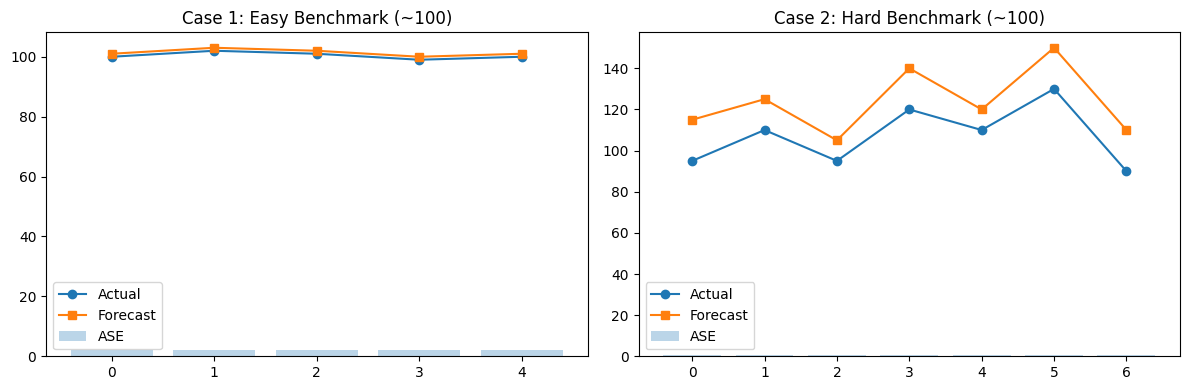

In [7]:
#@title Relative measures
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Case 1: Easy benchmark (values ~100) ---
y1 = np.array([100, 102, 101, 99, 100])
yhat1 = np.array([101, 103, 102, 100, 101])   # forecast is off by ~1
abs_err1 = np.abs(y1 - yhat1)

# Strong benchmark → tiny errors
benchmark_err1 = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
scale1 = benchmark_err1.mean()
ase1 = abs_err1 / scale1

# --- Case 2: Hard benchmark (values ~100, volatile series) ---
y2 = np.array([95, 110, 95, 120, 110, 130, 90])
yhat2 = np.array([115, 125, 105, 140, 120, 150, 110])  # consistently overshoots by ~20
abs_err2 = np.abs(y2 - yhat2)

# Weak benchmark → large errors (e.g., naive forecast with MAE ~25)
benchmark_err2 = np.array([25, 25, 25, 25, 25, 25, 25])
scale2 = benchmark_err2.mean()
ase2 = abs_err2 / scale2

# --- Build metrics summary ---
df_summary = pd.DataFrame([
    {
        "Case": "Easy benchmark (~100)",
        "Forecast MAE": abs_err1.mean(),
        "Benchmark MAE": scale1,
        "ASE (mean)": ase1.mean()
    },
    {
        "Case": "Hard benchmark (~100)",
        "Forecast MAE": abs_err2.mean(),
        "Benchmark MAE": scale2,
        "ASE (mean)": ase2.mean()
    }
])

print("=== Metrics Summary ===")
print(df_summary.round(2))

# --- Plot both cases ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Case 1 plot
axes[0].plot(y1, label="Actual", marker="o")
axes[0].plot(yhat1, label="Forecast", marker="s")
axes[0].bar(range(len(ase1)), ase1, alpha=0.3, label="ASE")
axes[0].set_title("Case 1: Easy Benchmark (~100)")
axes[0].legend()

# Case 2 plot
axes[1].plot(y2, label="Actual", marker="o")
axes[1].plot(yhat2, label="Forecast", marker="s")
axes[1].bar(range(len(ase2)), ase2, alpha=0.3, label="ASE")
axes[1].set_title("Case 2: Hard Benchmark (~100)")
axes[1].legend()

plt.tight_layout()
plt.show()


## 4). Forecast Bias (FB)

  $$
  FB = \frac{\sum_{t=1}^{n} \left( \hat{y}_t - y_t \right)}{\sum_{t=1}^{n} y_t}
  $$

- If FB > 0 → forecasts are too high on average (over-forecasting).
- If FB < 0 → forecasts are too low on average (under-forecasting).
- If FB ≈ 0 → forecasts are unbiased overall (no consistent lean up or down).


# Guidelines for choosing a metric

[survey paper by Hewamalage et al. ](https://arxiv.org/abs/2203.10716), the number of metrics that
was covered stands at **38**.

| Situation / data trait                    | Prefer                   | Also report | Avoid / caution        | Why                                                             |
| ----------------------------------------- | ------------------------ | ----------- | ---------------------- | --------------------------------------------------------------- |
| Single series, no zeros, comparable scale | **MAE**                  | RMSE        | —                      | MAE is interpretable; RMSE highlights large misses.             |
| Many series, different scales (panel)     | **MASE**                 | RMSSE       | Raw MAE/RMSE           | Scaled by in-sample naïve → comparable across series.           |
| Zeros or near-zeros present               | **MASE** or **WAPE**     | RMSSE       | **MAPE/RMSPE**         | Avoid division by small actuals; WAPE works at portfolio level. |
| Heavy tails / outliers                    | **MdAE** / **MdRAE**     | GMRAE       | Mean-only aggregations | Median/geometric means reduce outlier domination.               |
| Strong seasonal structure                 | **sMASE / sRMSSE**       | —           | Non-seasonal scaling   | Use seasonal naïve (lag = season length) as the scale.          |
| Stakeholders want “% of demand” summary   | **WAPE**                 | MASE        | MAPE                   | WAPE = total abs error / total demand; stable with zeros.       |
| Need benchmark-relative view              | **MRAE / MdRAE / GMRAE** | MASE        | —                      | Shows gains vs a chosen benchmark.                              |
| Want to penalize large misses more        | **RMSE / RMSSE**         | —           | MAE as sole metric     | Quadratic penalty. Pair with MAE/MASE for balance.              |




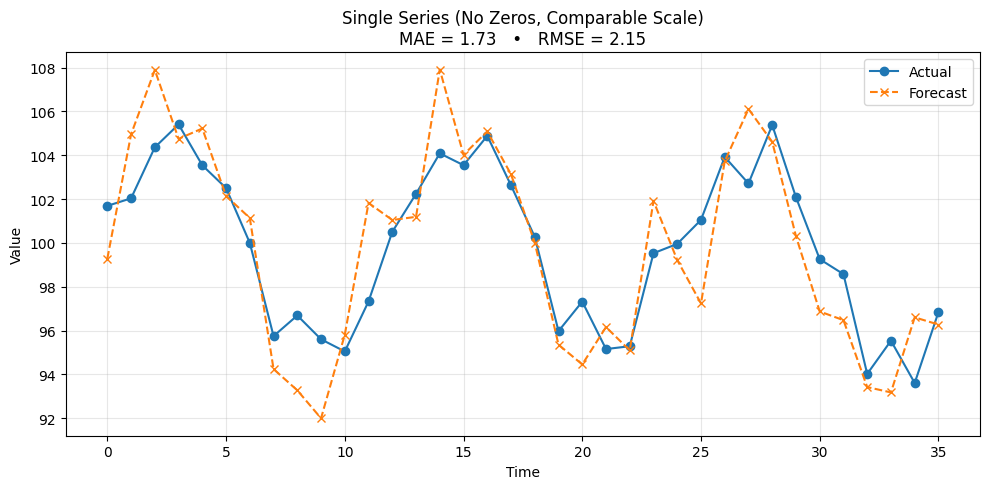

In [8]:
#@title 1). Single series, no zeros, comparable scale | MAE + RMSE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Synthetic single series (no zeros, comparable scale) ---
np.random.seed(7)
n = 36
time = np.arange(n)
actual = 100 + 5*np.sin(2*np.pi*time/12) + np.random.normal(0, 1.0, n)   # around 100, seasonal-ish
forecast = actual + np.random.normal(0, 2.0, n)                           # small unbiased noise around actual

# Ensure strictly positive (no zeros) and similar scale
actual = np.maximum(actual, 80)
forecast = np.maximum(forecast, 80)

# Metrics
abs_errors = np.abs(actual - forecast)
mae = abs_errors.mean()
rmse = np.sqrt(((actual - forecast) ** 2).mean())

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time, actual, marker="o", label="Actual")
plt.plot(time, forecast, marker="x", linestyle="--", label="Forecast")
plt.title(f"Single Series (No Zeros, Comparable Scale)\nMAE = {mae:.2f}   •   RMSE = {rmse:.2f}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


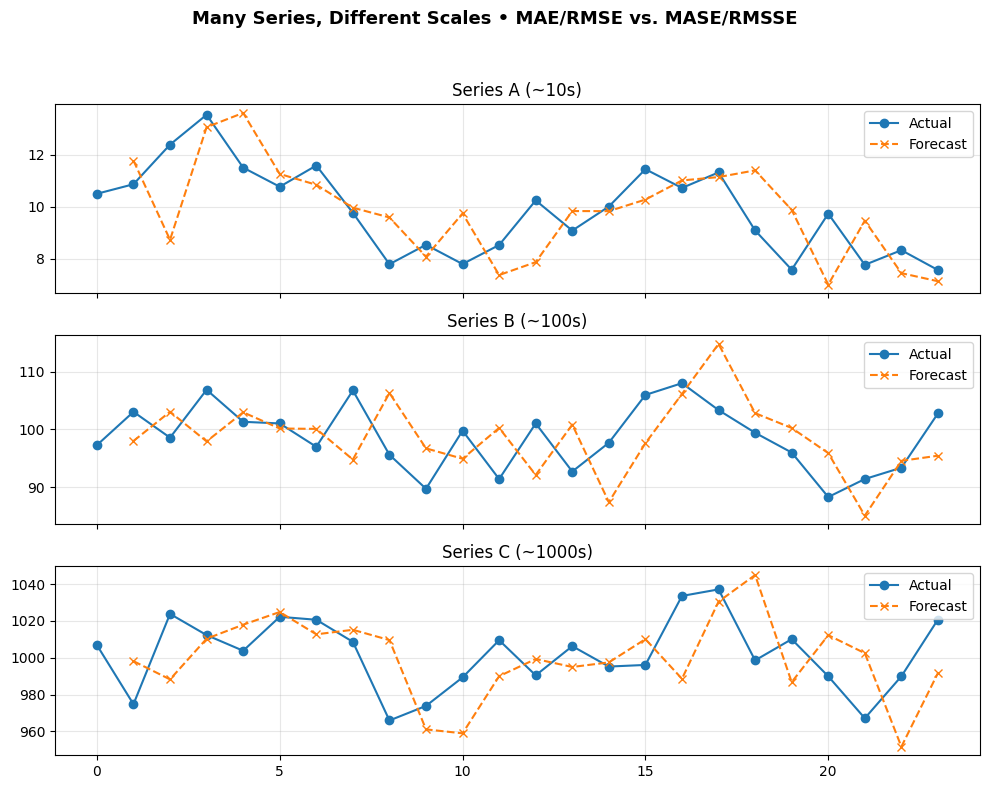

Summary metrics:
              Series     MAE    RMSE   MASE  RMSSE
0    Series A (~10s)   1.266   1.581  1.030  1.164
1   Series B (~100s)   6.383   7.191  1.039  1.055
2  Series C (~1000s)  20.934  25.319  1.060  1.071


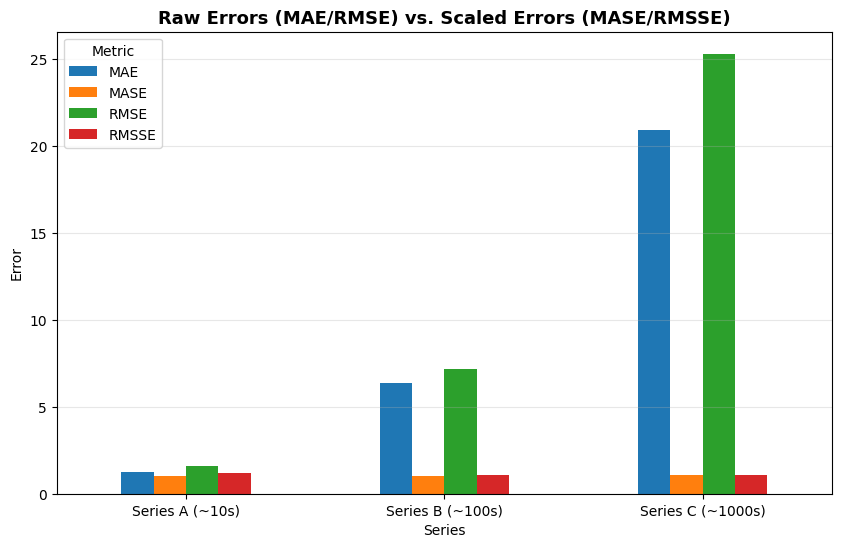

In [9]:
#@title 2). Many series, different scales | Prefer MASE & RMSSE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
n = 24
time = np.arange(n)

# --- Three synthetic series with different scales ---
series = {
    "Series A (~10s)": 10 + 2*np.sin(2*np.pi*time/12) + np.random.normal(0, 1, n),
    "Series B (~100s)": 100 + 5*np.sin(2*np.pi*time/12) + np.random.normal(0, 5, n),
    "Series C (~1000s)": 1000 + 20*np.sin(2*np.pi*time/12) + np.random.normal(0, 20, n),
}

# --- Forecast: naive forecast with added noise ---
forecasts = {}
for name, y in series.items():
    naive = np.r_[np.nan, y[:-1]]  # naive forecast (t-1)
    yhat = naive + np.random.normal(0, 0.5*np.std(y), size=n)
    forecasts[name] = yhat

# --- Metric functions (skip NaN at t=0) ---
def mae(y, yhat):
    return np.mean(np.abs(y[1:] - yhat[1:]))

def rmse(y, yhat):
    return np.sqrt(np.mean((y[1:] - yhat[1:])**2))

def mase(y, yhat):
    naive = np.r_[np.nan, y[:-1]]
    scale = np.nanmean(np.abs(y[1:] - naive[1:]))
    return np.mean(np.abs(y[1:] - yhat[1:])) / scale

def rmsse(y, yhat):
    naive = np.r_[np.nan, y[:-1]]
    scale = np.nanmean((y[1:] - naive[1:])**2)
    return np.sqrt(np.mean((y[1:] - yhat[1:])**2) / scale)

# --- Compute metrics ---
metrics = []
for name in series.keys():
    y, yhat = series[name], forecasts[name]
    metrics.append({
        "Series": name,
        "MAE": mae(y, yhat),
        "RMSE": rmse(y, yhat),
        "MASE": mase(y, yhat),
        "RMSSE": rmsse(y, yhat),
    })
df_metrics = pd.DataFrame(metrics)

# --- Panel plot of actual vs forecast ---
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for ax, (name, y) in zip(axes, series.items()):
    yhat = forecasts[name]
    ax.plot(time, y, marker="o", label="Actual")
    ax.plot(time, yhat, marker="x", linestyle="--", label="Forecast")
    ax.set_title(name)
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.suptitle("Many Series, Different Scales • MAE/RMSE vs. MASE/RMSSE",
             fontsize=13, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("Summary metrics:")
print(df_metrics.round(3))

# --- Bar chart comparison ---
df_plot = df_metrics.melt(id_vars="Series", value_vars=["MAE","RMSE","MASE","RMSSE"],
                          var_name="Metric", value_name="Value")

fig, ax = plt.subplots(figsize=(10,6))
df_plot.pivot(index="Series", columns="Metric", values="Value").plot(
    kind="bar", ax=ax, rot=0
)
ax.set_ylabel("Error")
ax.set_title("Raw Errors (MAE/RMSE) vs. Scaled Errors (MASE/RMSSE)", fontsize=13, weight="bold")
ax.grid(axis="y", alpha=0.3)
plt.show()


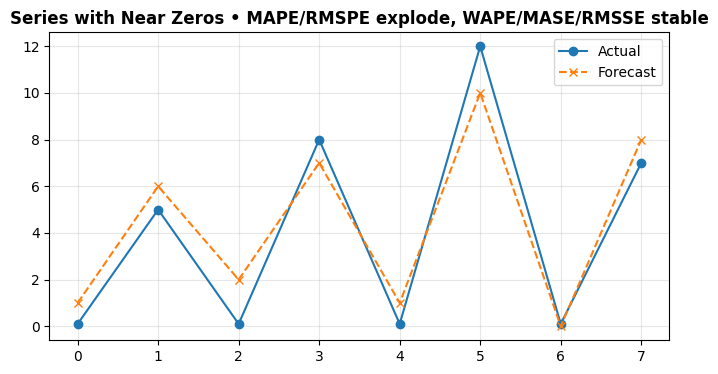

,MAE,RMSE,MAPE,RMSPE,WAPE,MASE,RMSSE
0,1.1,1.237,482.932,809.401,27.16,0.137,0.146


/tmp/ipython-input-1519890900.py:68: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y - yhat) / y)) * 100  # <-- problem: division by 0
/tmp/ipython-input-1519890900.py:68: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.abs((y - yhat) / y)) * 100  # <-- problem: division by 0
/tmp/ipython-input-1519890900.py:70: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt(np.mean(((y - yhat) / y)**2)) * 100
/tmp/ipython-input-1519890900.py:70: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(np.mean(((y - yhat) / y)**2)) * 100


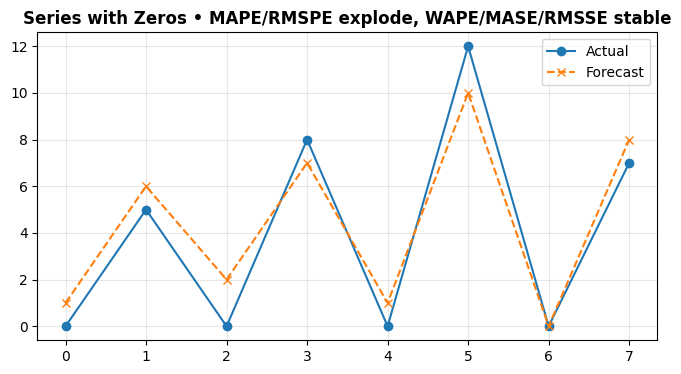

,MAE,RMSE,MAPE,RMSPE,WAPE,MASE,RMSSE
0,1.125,1.275,NaN,NaN,28.125,0.138,0.149


In [14]:
#@title 3). Zeros or near-zeros present
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Actual series with zeros (e.g. intermittent demand) ---
y = np.array([0.1, 5, 0.1, 8, 0.1, 12, 0.1, 7])
# Forecasts (reasonable but not perfect)
yhat = np.array([1, 6, 2, 7, 1, 10, 0, 8])

# --- Metric functions ---
def mae(y, yhat): return np.mean(np.abs(y - yhat))
def rmse(y, yhat): return np.sqrt(np.mean((y - yhat)**2))
def mape(y, yhat):
    return np.mean(np.abs((y - yhat) / y)) * 100  # <-- problem: division by 0
def rmspe(y, yhat):
    return np.sqrt(np.mean(((y - yhat) / y)**2)) * 100
def wape(y, yhat):
    return np.sum(np.abs(y - yhat)) / np.sum(np.abs(y)) * 100
def mase(y, yhat):
    naive = np.r_[np.nan, y[:-1]]  # seasonal naive (lag-1)
    scale = np.nanmean(np.abs(y[1:] - naive[1:]))
    return np.mean(np.abs(y - yhat)) / scale
def rmsse(y, yhat):
    naive = np.r_[np.nan, y[:-1]]
    scale = np.nanmean((y[1:] - naive[1:])**2)
    return np.sqrt(np.mean((y - yhat)**2) / scale)

# --- Compute metrics ---
metrics = {
    "MAE": mae(y,yhat),
    "RMSE": rmse(y,yhat),
    "MAPE": mape(y,yhat),   # will blow up
    "RMSPE": rmspe(y,yhat), # will blow up
    "WAPE": wape(y,yhat),
    "MASE": mase(y,yhat),
    "RMSSE": rmsse(y,yhat)
}

df_metrics = pd.DataFrame([metrics])



# --- Plot ---
plt.figure(figsize=(8,4))
plt.plot(y, marker="o", label="Actual")
plt.plot(yhat, marker="x", linestyle="--", label="Forecast")
plt.title("Series with Near Zeros • MAPE/RMSPE explode, WAPE/MASE/RMSSE stable", weight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
display(df_metrics.round(3))
print("\n")
#@title Zeros or near-zeros present
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Actual series with zeros (e.g. intermittent demand) ---
y = np.array([0, 5, 0, 8, 0, 12, 0, 7])
# Forecasts (reasonable but not perfect)
yhat = np.array([1, 6, 2, 7, 1, 10, 0, 8])

# --- Metric functions ---
def mae(y, yhat): return np.mean(np.abs(y - yhat))
def rmse(y, yhat): return np.sqrt(np.mean((y - yhat)**2))
def mape(y, yhat):
    return np.mean(np.abs((y - yhat) / y)) * 100  # <-- problem: division by 0
def rmspe(y, yhat):
    return np.sqrt(np.mean(((y - yhat) / y)**2)) * 100
def wape(y, yhat):
    return np.sum(np.abs(y - yhat)) / np.sum(np.abs(y)) * 100
def mase(y, yhat):
    naive = np.r_[np.nan, y[:-1]]  # seasonal naive (lag-1)
    scale = np.nanmean(np.abs(y[1:] - naive[1:]))
    return np.mean(np.abs(y - yhat)) / scale
def rmsse(y, yhat):
    naive = np.r_[np.nan, y[:-1]]
    scale = np.nanmean((y[1:] - naive[1:])**2)
    return np.sqrt(np.mean((y - yhat)**2) / scale)

# --- Compute metrics ---
metrics = {
    "MAE": mae(y,yhat),
    "RMSE": rmse(y,yhat),
    "MAPE": mape(y,yhat),   # will blow up
    "RMSPE": rmspe(y,yhat), # will blow up
    "WAPE": wape(y,yhat),
    "MASE": mase(y,yhat),
    "RMSSE": rmsse(y,yhat)
}

df_metrics = pd.DataFrame([metrics])



# --- Plot ---
plt.figure(figsize=(8,4))
plt.plot(y, marker="o", label="Actual")
plt.plot(yhat, marker="x", linestyle="--", label="Forecast")
plt.title("Series with Zeros • MAPE/RMSPE explode, WAPE/MASE/RMSSE stable", weight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

display(df_metrics.round(3))


WAPE: 8.78% Across all products/periods, our forecasts were off by 8.78% of total demand.
MAPE: 20.0


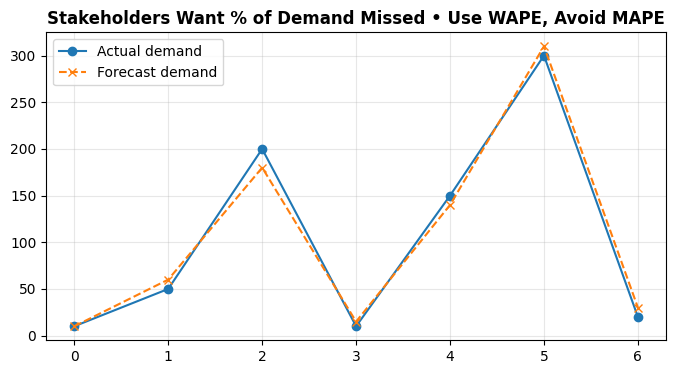

In [15]:
#@title 4). Stakeholders want “% of demand” summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Actual weekly demand (note zeros + small values) ---
y = np.array([10, 50, 200, 10, 150, 300, 20])
# Forecast demand
yhat = np.array([10, 60, 180, 15, 140, 310, 30])

# --- Metrics ---
def wape(y, yhat):
    return np.sum(np.abs(y - yhat)) / np.sum(np.abs(y)) * 100

def mape(y, yhat):
    return np.mean(np.abs((y - yhat) / y)) * 100  # <-- blows up with zeros

# --- Compute ---
WAPE = wape(y,yhat)
try:
    MAPE = mape(y,yhat)
except Warning:
    MAPE = "inf / NaN"

print(f"WAPE: {WAPE:.2f}%",f"Across all products/periods, our forecasts were off by {WAPE:.2f}% of total demand.")
print(f"MAPE: {MAPE}")

plt.figure(figsize=(8,4))
plt.plot(y, marker="o", label="Actual demand")
plt.plot(yhat, marker="x", linestyle="--", label="Forecast demand")
plt.title("Stakeholders Want % of Demand Missed • Use WAPE, Avoid MAPE", weight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


- **Weighted Absolute Percentage Error (WAPE):**

  $$
  WAPE = \frac{\sum_{t=1}^{n} \lvert y_t - \hat{y}_t \rvert}{\sum_{t=1}^{n} \lvert y_t \rvert} \times 100\%
  $$


# Summary
**1. Classical**
- **MAE** (Mean Absolute Error)  
- **RMSE** (Root Mean Squared Error)  

**2. Scale-independent / Percentage-based**
- **sMAPE** (Symmetric Mean Absolute Percentage Error)  
- **WAPE** (Weighted Absolute Percentage Error)  

**3. Benchmark-relative**
- **MASE** (Mean Absolute Scaled Error)  
- **RMSSE** (Root Mean Squared Scaled Error)  

**4. Over/under-forecasting**
- **Forecast Bias (FB)**  
- **Tracking Signal (TS)**

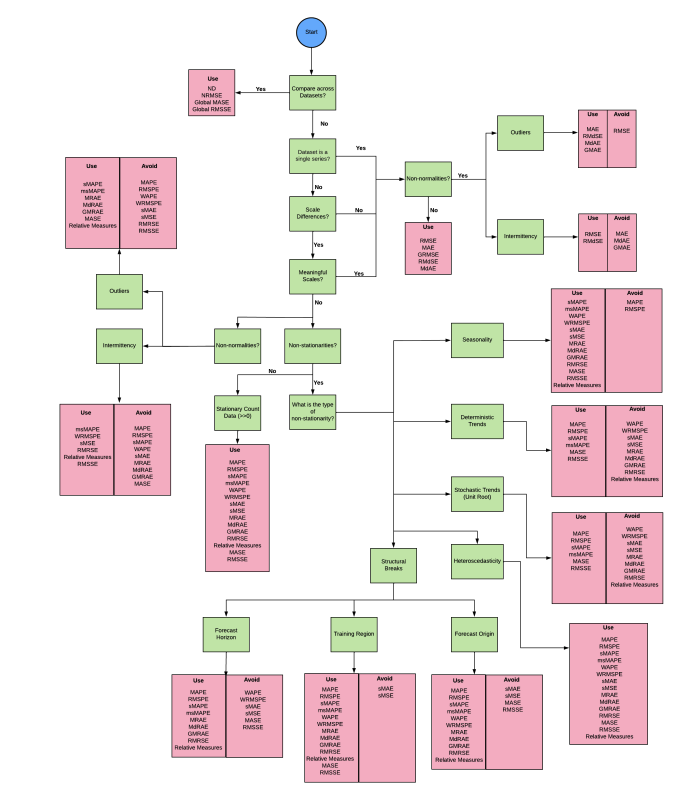

# Practice

Metrics: overall vs daytime-only (plus demand-weighted)


,Scope,MAE,RMSE,WAPE (%),MASE (s=24),RMSSE (s=24),Demand-weighted MAE
0,Overall,11.706,17.572,42.833,2.257,2.054,22.479
1,Daytime only,21.368,23.873,42.933,2.257,2.054,22.784


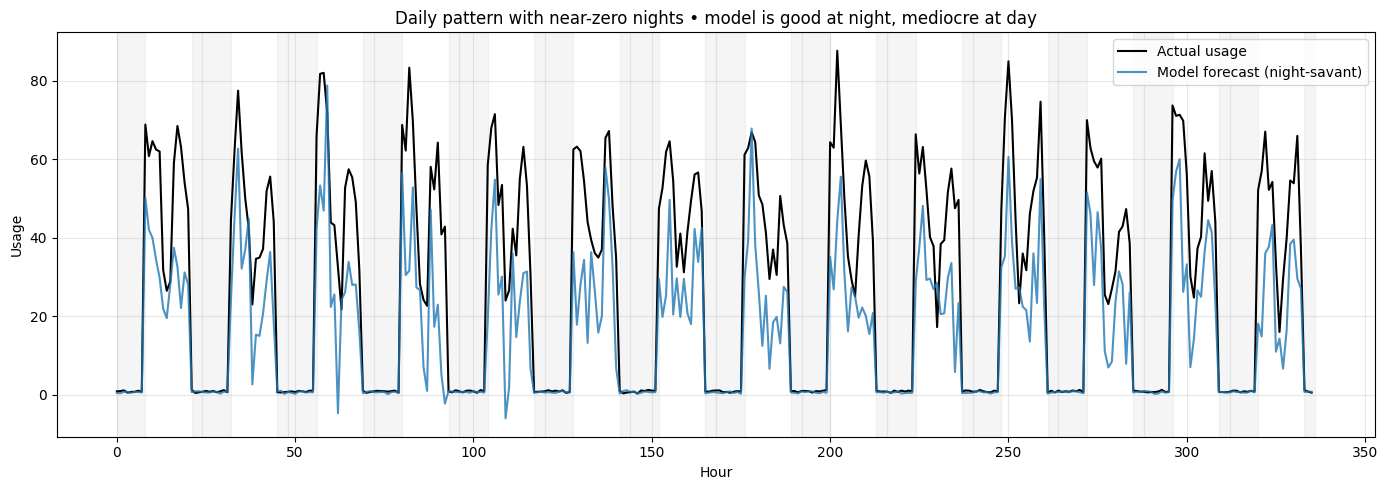

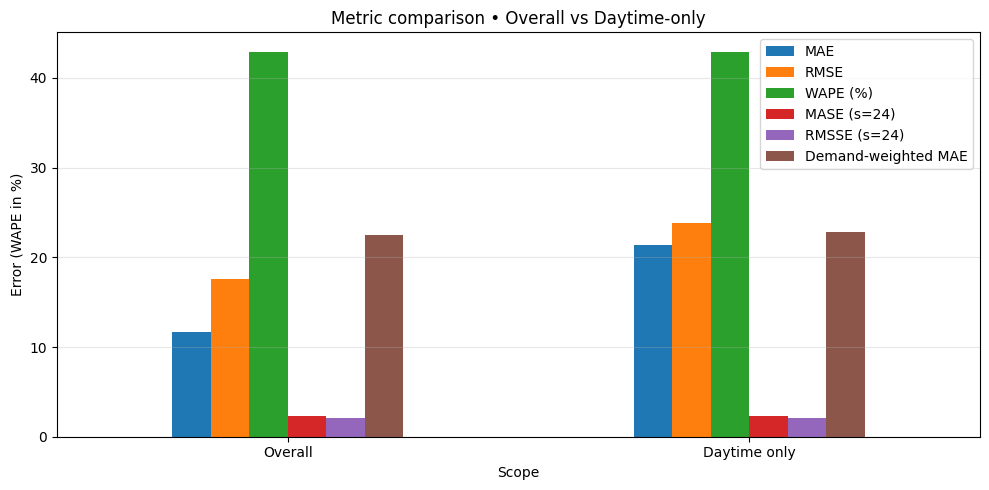

In [39]:
#@title near-zero nights and fluctuating days,
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


np.random.seed(123)

# --- 1) Synthesize a diurnal usage series (hourly for 14 days) ---
days = 14
H = 24 * days
t = np.arange(H)
hour = t % 24

# Daytime hours (8am–8pm) high usage with fluctuations; night near-zero
is_day = (hour >= 8) & (hour <= 20)
base = np.where(is_day, 50 + 10*np.sin(2*np.pi*hour/24) + 15*np.sin(2*np.pi*hour/8), 0.8)
noise = np.where(is_day, np.random.normal(0, 8, H), np.random.normal(0, 0.2, H))
y = np.clip(base + noise, 0, None)  # actual usage

# --- A model that is great at night but mediocre at day ("night-savant") ---
yhat = np.where(is_day, 0.6*y + np.random.normal(0, 10, H), 0.6 + np.random.normal(0, 0.2, H))

# --- Seasonal naive benchmark (lag-24) for scaled/relative errors ---
y_bench = np.r_[ [np.nan]*24, y[:-24] ]

# --- Helper metrics ---
def mae(y, yhat):
    return np.mean(np.abs(y - yhat))

def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

def wape(y, yhat):
    num = np.sum(np.abs(y - yhat))
    den = np.sum(np.abs(y))
    return np.nan if den == 0 else 100*num/den

def mase(y, yhat, s=24):
    y_ins = y[s:]
    naive = y[:-s]
    scale = np.mean(np.abs(y_ins - naive))
    return np.mean(np.abs(y[s:] - yhat[s:])) / (scale if scale != 0 else np.nan)

def rmsse(y, yhat, s=24):
    y_ins = y[s:]
    naive = y[:-s]
    scale = np.mean((y_ins - naive)**2)
    return np.sqrt(np.mean((y[s:] - yhat[s:])**2) / (scale if scale != 0 else np.nan))

# Masks
mask_day = is_day
mask_night = ~is_day

# --- 2) Compute metrics (overall vs daytime-only) ---
metrics = {
    "Scope": ["Overall", "Daytime only"],
    "MAE":   [mae(y, yhat), mae(y[mask_day], yhat[mask_day])],
    "RMSE":  [rmse(y, yhat), rmse(y[mask_day], yhat[mask_day])],
    "WAPE (%)": [wape(y, yhat), wape(y[mask_day], yhat[mask_day])],
    "MASE (s=24)": [mase(y, yhat, 24), mae(y[24:], yhat[24:]) / np.mean(np.abs(y[24:] - y[:-24]))],
    "RMSSE (s=24)": [rmsse(y, yhat, 24), rmse(y[24:], yhat[24:]) / np.sqrt(np.mean((y[24:] - y[:-24])**2))]
}
df_metrics = pd.DataFrame(metrics)

# --- 3) Demand-weighted MAE to reduce night dilution ---
def demand_weighted_mae(y, yhat):
    weights = y / (np.sum(y) + 1e-12)  # weights sum to 1; night ~0 weight
    return np.sum(weights * np.abs(y - yhat))

dwmae_overall = demand_weighted_mae(y, yhat)
dwmae_day = demand_weighted_mae(y[mask_day], yhat[mask_day])

# Add to table
df_metrics["Demand-weighted MAE"] = [dwmae_overall, dwmae_day]

# Display metrics
print("Metrics: overall vs daytime-only (plus demand-weighted)")
display(df_metrics.round(3))

# --- 1) Plot the time series with day/night shading ---
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(t, y, label="Actual usage", color="black", linewidth=1.5)
ax.plot(t, yhat, label="Model forecast (night-savant)", color="tab:blue", alpha=0.8)

# Shade night hours
for d in range(days):
    night1 = np.arange(d*24, d*24+8)     # 0-7
    night2 = np.arange(d*24+21, d*24+24) # 21-23
    for block in [night1, night2]:
        if len(block)>0:
            ax.axvspan(block[0], block[-1]+1, color="gray", alpha=0.08)

ax.set_title("Daily pattern with near-zero nights • model is good at night, mediocre at day")
ax.set_xlabel("Hour")
ax.set_ylabel("Usage")
ax.legend(loc="upper right")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- 4) Bar chart comparing metric variants (Overall vs Daytime) ---
cols = ["MAE", "RMSE", "WAPE (%)", "MASE (s=24)", "RMSSE (s=24)", "Demand-weighted MAE"]
fig, ax = plt.subplots(figsize=(10,5))
df_metrics.set_index("Scope")[cols].plot(kind="bar", ax=ax, rot=0)
ax.set_title("Metric comparison • Overall vs Daytime-only")
ax.set_ylabel("Error (WAPE in %)")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


/tmp/ipython-input-647733476.py:63: RuntimeWarning: divide by zero encountered in scalar divide
  hour_mase[h] = np.mean(np.abs(df.loc[mask,"y"] - df.loc[mask,"yhat"])) / scale


            Metric     Value
0   sMASE (lag=24)  0.859510
1  sRMSSE (lag=24)  0.711371
2     Weighted MAE  1.859574
3    Weighted RMSE  1.921214
4    Forecast Bias  0.188464


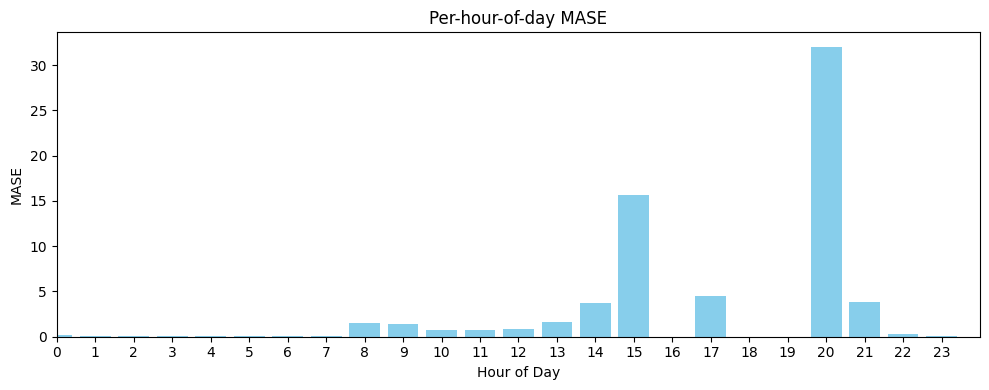

In [42]:
#@title Seasonal scaled errors + Custom weighting by hour-of-day + Segmented scorecard by hour-of-day
#@markdown (night hours downweighted, day hours fully weighted)
# --- Generate synthetic hourly series (14 days) ---
np.random.seed(42)
n_days = 14
hours = np.arange(24 * n_days)
y = 5 + 10*np.sin(2*np.pi*hours/24) + np.random.normal(0, 2, size=len(hours))  # daytime pattern
y = np.clip(y, 0.2, None)  # no zeros, small floor at night

# Forecast: biased slightly high in day, good at night
yhat = y.copy()
yhat += np.where((hours % 24 >= 8) & (hours % 24 <= 20), 2.0, 0.2)

# Seasonal naive benchmark (lag=24)
y_bench = np.r_[ [np.nan]*24, y[:-24] ]

df = pd.DataFrame({
    "t": hours,
    "hour": hours % 24,
    "is_day": ((hours % 24 >= 8) & (hours % 24 <= 20)).astype(int),
    "y": y,
    "yhat": yhat,
    "y_bench": y_bench
})

# --- Metric functions ---
def sMASE(y, yhat, y_bench):
    mask = ~np.isnan(y_bench)
    scale = np.mean(np.abs(y[mask] - y_bench[mask]))
    return np.mean(np.abs(y - yhat)) / scale

def sRMSSE(y, yhat, y_bench):
    mask = ~np.isnan(y_bench)
    scale = np.sqrt(np.mean((y[mask] - y_bench[mask])**2))
    return np.sqrt(np.mean((y - yhat)**2)) / scale

def weighted_mae(y, yhat, w):
    return np.sum(w * np.abs(y - yhat)) / np.sum(w)

def weighted_rmse(y, yhat, w):
    return np.sqrt(np.sum(w * (y - yhat)**2) / np.sum(w))

def forecast_bias(y, yhat):
    return np.sum(yhat - y) / np.sum(y)

# --- 1. Seasonal scaled errors (lag=24) ---
s_mase = sMASE(df["y"].values, df["yhat"].values, df["y_bench"].values)
s_rmsse = sRMSSE(df["y"].values, df["yhat"].values, df["y_bench"].values)

# --- 2. Weighted MAE/RMSE (weights by hour of day) ---
weights = np.where(df["is_day"]==1, 1.0, 0.1)
wmae = weighted_mae(df["y"].values, df["yhat"].values, weights)
wrmse = weighted_rmse(df["y"].values, df["yhat"].values, weights)

# --- 3. Segmented scorecard (per-hour-of-day MASE) ---
hour_mase = {}
for h in range(24):
    mask = (df["hour"]==h) & (~df["y_bench"].isna())
    if mask.sum() > 0:
        scale = np.mean(np.abs(df.loc[mask,"y"] - df.loc[mask,"y_bench"]))
        hour_mase[h] = np.mean(np.abs(df.loc[mask,"y"] - df.loc[mask,"yhat"])) / scale
    else:
        hour_mase[h] = np.nan

# Aggregate with weights proportional to actual demand per hour
hour_weights = df.groupby("hour")["y"].sum()

# --- 4. Forecast Bias ---
fb = forecast_bias(df["y"].values, df["yhat"].values)

# --- Results ---
results = pd.DataFrame({
    "Metric": ["sMASE (lag=24)", "sRMSSE (lag=24)",
               "Weighted MAE", "Weighted RMSE",
               "Forecast Bias"],
    "Value": [s_mase, s_rmsse, wmae, wrmse, fb]
})
print(results)


hours = list(range(24))
values = [hour_mase[h] for h in hours]

plt.figure(figsize=(10,4))
plt.bar(hours, values, color="skyblue")
plt.title("Per-hour-of-day MASE")
plt.xlabel("Hour of Day")
plt.ylabel("MASE")
plt.xlim(0, 24)   # force x-axis 0–24
plt.xticks(hours)
plt.tight_layout()
plt.show()

